In [199]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from ltp import LTP
import jieba


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [6]:
jieba.load_userdict(r"./userdict.txt")
ltp = LTP()

### Import data and data preprocessing

In [139]:
def str_preparsing(input_str):
    # 删除html tags
    out = re.sub("https*\S+/", "", input_str)
    out = re.sub("<[^>]*>", "", out)
    
    # 删除数字
    punc = u'0123456789.'
    out = re.sub(r'[{}]+'.format(punc), '', out)
    
    # 删除空格
    out = re.sub(r'[\s\t]','',out)
    return out

In [140]:
with open(r"./mergeAll.txt",encoding='utf-8') as f:
    data = json.loads(f.readline())

res = []
for k in data:
    for m in k[2]:
        res.append(str_preparsing(m['content']))

In [141]:
df = pd.DataFrame(res, columns=['content']) 
df.drop_duplicates(subset=['content'],keep='first',inplace=True)

df['match_key']=df['content'].str.contains('Nike|耐克|nike|NIKE' and '销量|年报|股票|财报|战略|裁员|亏损|盈利|营收|转型')
df=df.loc[df['match_key']==True]

In [142]:
df['len']=df.content.str.len()

In [143]:
df.head()

,content,match_key,len
0,#时尚##股票#《今日美国》根据研究报告以及对华尔街股票分析师的采访汇总了年的只将继续上涨的...,True,154
1,原标题：快报|Nike成华尔街分析师最看好的时尚类股票；Guess发布全新五年战略计划；佐丹...,True,1071
2,王鹤棣上脚Nikefearofgod，上帝灰配色质感十足！这双nike和fog的联名因为不错...,True,345
3,"【CPS中安网cpscomcn】月日，""世茂集团获奖战略供应商大会""在上海举行，作为世茂集团...",True,958
4,"【CPS中安网cpscomcn】近日，由全联房地产商会主办的""中国房地产产业链年度盛典""在北...",True,1072


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f9b5eb8>]],
      dtype=object)

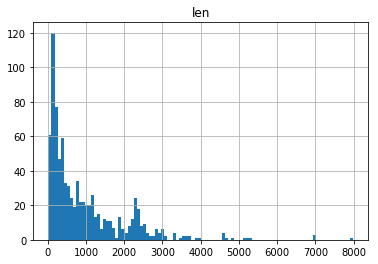

In [178]:
df['len']=df.content.str.len()
df.hist(column='len', bins=100)

In [144]:
df.shape

(845, 3)

### Text Preparsing

In [174]:
# 分句 / 分词 两种不同包都可以用
def jieba_wordsep(corpus):
    word_sep = jieba.lcut(corpus.strip())
    return word_sep

def ltp_wordsep(corpus):
    word_sep, hidden = ltp.seg(ltp.sent_split([corpus]))
    return sum(word_sep,[])


# 去停用词
def move_stopwords(doc, stopwords_file, encoding = 'UTF-8'):
    stopwords = set([line.strip() for line in open(stopwords_file,encoding=encoding).readlines()])
    out_list = []
    for word in doc:
        if word not in stopwords:
            out_list.append(word)
    return out_list

def get_wordcut(corpus, text_out = True):
    doc = jieba_wordsep(corpus)
    word_cut = move_stopwords(doc, r'./stoplist.txt')
    if text_out:
        return ' '.join(word_cut)
    else:
        return word_cut

In [175]:
# example
ex = df.content.values[7]
out1 = jieba_wordsep(ex)
out2 = ltp_wordsep(ex)
print('/'.join(out1))
print('/'.join(out2))

蒙口/最近/的/新衣/真是/越来越/好看/了/！/鞋子/也/不/例外/，/其/运动/机能/远超/阿迪/耐克/成为/鞋界/的/“/销量/王/”
蒙口/最近/的/新衣/真是/越来越/好看/了/！/鞋子/也/不/例外/，/其/运动机能/远超/阿迪耐克/成为/鞋界/的/“/销量王/”


In [176]:
df["content_cutted"] = df.content.apply(get_wordcut)

In [179]:
df.head()

,content,match_key,len,content_cutted
0,#时尚##股票#《今日美国》根据研究报告以及对华尔街股票分析师的采访汇总了年的只将继续上涨的...,True,154,时尚 股票 今日美国 研究报告 华尔街 股票 分析师 采访 汇总 上涨 股票 科技 巨头 苹...
1,原标题：快报|Nike成华尔街分析师最看好的时尚类股票；Guess发布全新五年战略计划；佐丹...,True,1071,Nike 华尔街分析师 看好 时尚 类股票 Guess 发布 全新 五年 战略 计划 佐丹奴...
2,王鹤棣上脚Nikefearofgod，上帝灰配色质感十足！这双nike和fog的联名因为不错...,True,345,上帝灰 配色 质感 十足 这双 nike fog 联名 不错 颜值 质感 高 销量 发售 之...
3,"【CPS中安网cpscomcn】月日，""世茂集团获奖战略供应商大会""在上海举行，作为世茂集团...",True,958,世茂集团 获奖 战略 供应商 大会 上海 世茂集团 携手 战略 合作伙伴 狄耐克 应邀 与会...
4,"【CPS中安网cpscomcn】近日，由全联房地产商会主办的""中国房地产产业链年度盛典""在北...",True,1072,全联房地产商会 主办 中国 房地产 产业链 年度 盛典 北京 隆重召开 狄耐克 副总经理 侯...


### 文本向量化

In [220]:
# count_vectorizer
n_features = 1000
cv_model = CountVectorizer(strip_accents = 'unicode',max_features=n_features, max_df = 0.6)
cv_vect = cv_model.fit_transform(df.content_cutted)

In [181]:
# Tf-Idf
tfidf_model = TfidfVectorizer(max_features=n_features,analyzer='word',token_pattern=r"(?u)\b\w+\b", max_df=.6)
tfidf_vect = tfidf_model.fit_transform(df.content_cutted)

In [ ]:
# 基于上下文生成对应向量

In [197]:
def distinct_words(corpus):
    corp = [y for x in corpus for y in x]
    corpus_words = sorted(list(set(corp)))
    n_corpus_words = len(corpus_words)

    return corpus_words, n_corpus_words

def get_cooccur_word(word, text, window_size, upper = []):
    if word in text:
        idx = text.index(word)
        out = upper.copy()
        out.extend(text[idx + 1:idx + window_size + 1])
        return get_cooccur_word(word, text[idx+1:], window_size, upper = out)
    else:
        return upper
    
def compute_co_occurrence_matrix(corpus, window_size=4):
    words, n_words = distinct_words(corpus)
    M = []
    word2ind = {}
    
    for idx, word in enumerate(words):
        word2ind[word] = idx
    for word, idx in word2ind.items():
        curr_L = [0]*n_words
        curr_corp = []
        for text in corpus:
            curr_corp.append(get_cooccur_word(word, text, window_size))
            text.reverse()
            curr_corp.append(get_cooccur_word(word, text, window_size))
        curr_corp = [v for v in curr_corp if len(v)>0]
        cooccur_words, _ = distinct_words(curr_corp)
        for c in cooccur_words:
            curr_L[word2ind[c]] = 1
        M.append(curr_L)
    M = np.array(M)

    return M, word2ind

def reduce_to_k_dim(M, k=2):
    n_iters = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

In [191]:
corpus = []
for text in df.content:
    corpus.append(get_wordcut(text, text_out = False))

In [200]:
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

Running Truncated SVD over 19033 words...
Done.


In [202]:
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

In [206]:
def plot_embeddings(M_reduced, word2ind, words, labels = []):
    M_reduced2 = []
    for w in words:
        M_reduced2.append(M_reduced[word2ind[w]])
    M_reduced2 = np.array(M_reduced2)
    plt.scatter(M_reduced2.T[0],M_reduced2.T[1],color = 'r', marker = 'x')
    for i,w in enumerate(words):
        idx = word2ind[w]
        plt.annotate(labels[i], xy = M_reduced[idx], xytext = M_reduced[idx])

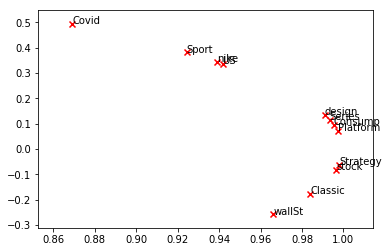

In [214]:
words = ['股票','设计','Nike','华尔街','消费','美国','经典','系列','战略','运动','疫情','平台']
label = ['stock','design','nike','wallSt','Consump','US','Classic','Series','Strategy','Sport','Covid','Platform']

plot_embeddings(M_normalized, word2ind_co_occurrence, words, labels = label)

### LDA topic Modeling

In [226]:
n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [227]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [228]:
lda.fit(cv_vect)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=6, random_state=0)

In [229]:
n_top_words = 10
feature_names = tfidf_model.get_feature_names()
print_top_words(lda, feature_names, n_top_words)

Topic #0:
周四 近 中东地区 工厂 渠道 亦 基金 闪光点 降 目标
Topic #1:
零售业 目标 周四 闪光点 关系 群体 吸引 形势 全年 时间表
Topic #2:
nba 长期 乔丹 群体 申洲 配送 财经 aj 线上 n
Topic #3:
言论 nba 事实上 股价 业主 吸引 销售 数字 零售商 实战
Topic #4:
全年 年初 发布 市场预期 奢侈品 深度 疫情 群体 言论 中东地区
Topic #5:
同一天 贵人 基金 目标 下跌 销售 闪光点 行业 外媒 全年


In [230]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook(local = True)
pyLDAvis.sklearn.prepare(lda, cv_vect, cv_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.179377 -0.052201       1        1  35.638529
0     -0.035288 -0.112906       2        1  20.665632
1     -0.078959 -0.044498       3        1  14.402777
4     -0.017969 -0.111309       4        1  13.453695
3      0.188192  0.178006       5        1   8.139007
2     -0.235353  0.142907       6        1   7.700360, topic_info=     Term         Freq        Total Category  logprob  loglift
848    裁员  1097.000000  1097.000000  Default  30.0000  30.0000
20   nike   934.000000   934.000000  Default  29.0000  29.0000
297    品牌  1900.000000  1900.000000  Default  28.0000  28.0000
958    集团   971.000000   971.000000  Default  27.0000  27.0000
870    财年  1442.000000  1442.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
540    收入    69.480922   628.288634   Topic6  -4.9395   0.3620
181    全球    74.592325  1413.405584   Topic6  -4.8685  -0.3778
886    超过    62.942379   313.225882   Topic6  -5.0384   0.9592
440    影响    69.979436  1114.300413   Topic6  -4.9324  -0.2039
297    品牌    68.148936  1900.804926   Topic6  -4.9589  -0.7644

[416 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         3  0.890517     adidas
0         6  0.107476     adidas
1         3  0.066418  airjordan
1         6  0.929854  airjordan
3         4  0.015060         aj
...     ...       ...        ...
988       3  0.304337      首席执行官
988       5  0.368633      首席执行官
992       4  0.983813         驾驶
998       2  0.992579        鬼冢虎
999       4  0.969892        麦当劳

[936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 5, 4, 3])